<a href="https://colab.research.google.com/github/fernando-marconi/DataScience-Combustivel-Previsao-e-Analise-de-Series-Temporais/blob/main/DataScience_Combustivel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto | Data Science**

In [1]:
# Frameworks
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de visualização para DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Montar Google Drive para acessar a Camada Ouro
from google.colab import drive
drive.mount('/content/drive')

# Caminho para o arquivo da Camada Ouro
# Ajuste este caminho se o seu arquivo Parquet estiver em outro local
CAMADA_OURO_PATH = '/content/drive/MyDrive/Projeto_combustivel/Ouro/analitico_dados_combustivel.parquet'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Ingestão de dados (Camada Ouro)
try:
    df = pd.read_parquet(CAMADA_OURO_PATH)
    print("Dados da Camada Ouro carregados com sucesso!")
except FileNotFoundError:
    print(f"ERRO: Arquivo não encontrado no caminho: {CAMADA_OURO_PATH}")
    print("Certifique-se de que o projeto anterior foi executado e o arquivo .parquet foi salvo.")

# Inspecionar as primeiras linhas e tipos de dados
print("\nPrimeiras Linhas (Head):")
print(df.head())

print("\nInformações sobre os tipos de dados (Info):")
df.info()

Dados da Camada Ouro carregados com sucesso!

Primeiras Linhas (Head):
         regiao regiao_sigla estado_sigla municipio data_mensal     ano  mes  \
0  centro-oeste           CO           DF  brasilia  2020-01-01  2020.0  1.0   
1  centro-oeste           CO           DF  brasilia  2020-02-01  2020.0  2.0   
2  centro-oeste           CO           DF  brasilia  2020-03-01  2020.0  3.0   
3  centro-oeste           CO           DF  brasilia  2020-04-01  2020.0  4.0   
4  centro-oeste           CO           DF  brasilia  2020-05-01  2020.0  5.0   

  produto  valor_medio_venda  
0  DIESEL           3.858696  
1  DIESEL           3.851470  
2  DIESEL           3.721009  
3  DIESEL           3.395297  
4  DIESEL           3.092258  

Informações sobre os tipos de dados (Info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127549 entries, 0 to 127548
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----     

In [3]:
# Pré-processamento para séries temporais

# Ordenar e preparar a série
# A coluna 'data_mensal' deve ser definida como o índice da série
df = df.sort_values(by=['regiao', 'produto', 'data_mensal'])
df = df.set_index('data_mensal')

# Análise de Missing Data
print("\nVerificação de valores nulos (Null Check):")
print(df.isnull().sum())

# Checagem de Estacionariedade e Frequência
# O índice deve estar em frequência mensal
print("\nFrequência da série:")
print(df.index.freq)
# Saída esperada é None, pois o índice ainda não está com uma frequência definida.

# Mostrar o DF pronto para o EDA
print("\nDataFrame após pré-processamento (Primeiras linhas):")
print(df.head())


Verificação de valores nulos (Null Check):
regiao               0
regiao_sigla         0
estado_sigla         0
municipio            0
ano                  0
mes                  0
produto              0
valor_medio_venda    0
dtype: int64

Frequência da série:
None

DataFrame após pré-processamento (Primeiras linhas):
                   regiao regiao_sigla estado_sigla              municipio  \
data_mensal                                                                  
2020-01-01   centro-oeste           CO           DF               brasilia   
2020-01-01   centro-oeste           CO           GO  aguas lindas de goias   
2020-01-01   centro-oeste           CO           GO               anapolis   
2020-01-01   centro-oeste           CO           GO   aparecida de goiania   
2020-01-01   centro-oeste           CO           GO           caldas novas   

                ano  mes produto  valor_medio_venda  
data_mensal                                          
2020-01-01   2020.0  1.

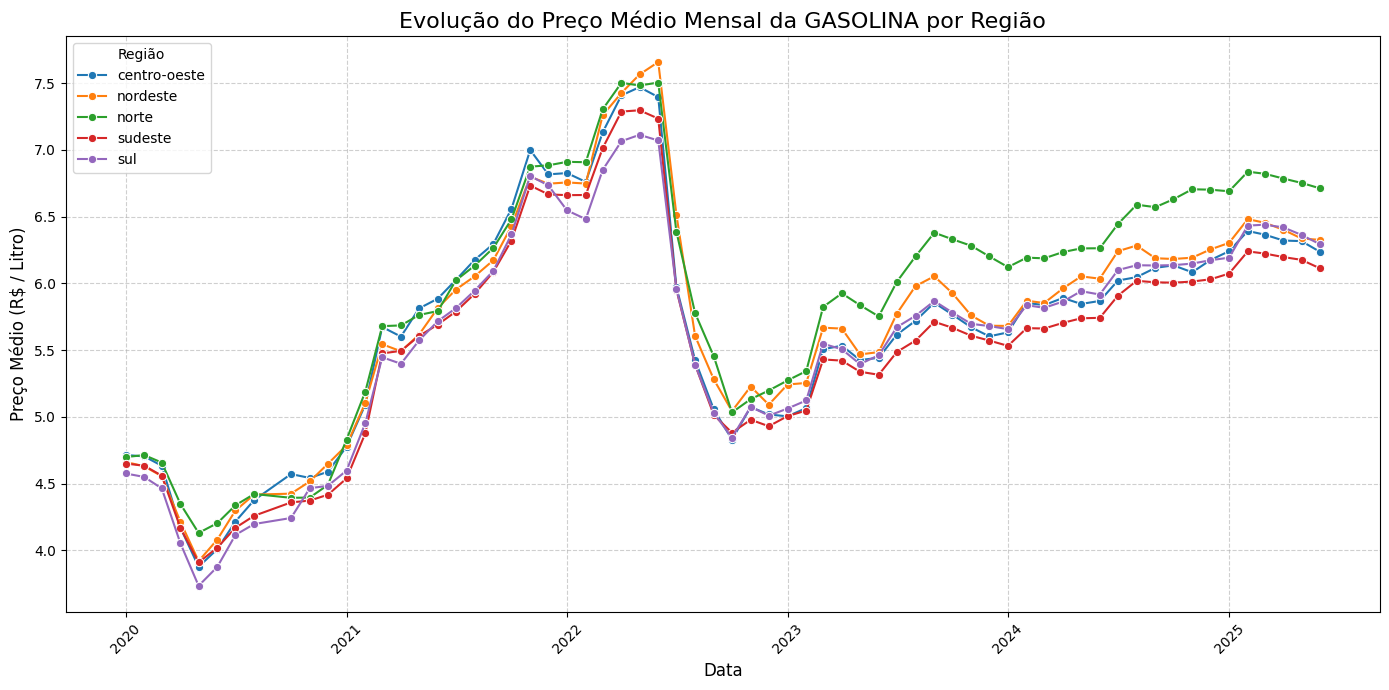

In [4]:
# Visualização: Preço Médio por Região (Produto Chave: Gasolina)

# Filtrar para um único produto para a visualização regional
df_gasolina = df[df['produto'] == 'GASOLINA']

# Reagrupar para calcular a média nacional por região (se houver múltiplas entradas por mês)
# E definir 'regiao' como a variável de cores
df_regional_gasolina = df_gasolina.groupby(['data_mensal', 'regiao']).agg(
    valor_medio_regiao = ('valor_medio_venda', 'mean')
).reset_index()

plt.figure(figsize=(14, 7))
sns.lineplot(
    data=df_regional_gasolina,
    x='data_mensal',
    y='valor_medio_regiao',
    hue='regiao',
    marker='o',
    dashes=False
)

plt.title('Evolução do Preço Médio Mensal da GASOLINA por Região', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço Médio (R$ / Litro)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.legend(title='Região', loc='upper left')
plt.tight_layout()
plt.savefig('eda_gasolina_regional.png')
plt.show()

In [5]:
# Criação da Série Nacional

# Calcular a média nacional de venda da GASOLINA por data_mensal
# Isto garante um único ponto de dado por período
ts_target = df_gasolina.groupby('data_mensal')['valor_medio_venda'].mean()

# Garantir que o índice seja um DatetimeIndex e forçar a frequência mensal ('MS' - Month Start)
ts_target.index = pd.to_datetime(ts_target.index)
ts_target = ts_target.asfreq('MS')

# Preenchimento de nulos (se existirem, geralmente com o valor do mês anterior)
# Embora os dados ANP sejam densos, esta é uma boa prática de séries temporais
ts_target = ts_target.fillna(method='ffill')

# Inspecionar a série final
print("Série Temporal (TS) para Modelagem:")
print(ts_target.head())
print(f"\nNúmero total de observações na série: {len(ts_target)}")

# Salvar a série em uma variável final
ts = ts_target

Série Temporal (TS) para Modelagem:
data_mensal
2020-01-01    4.647864
2020-02-01    4.629383
2020-03-01    4.554636
2020-04-01    4.170855
2020-05-01    3.895426
Freq: MS, Name: valor_medio_venda, dtype: float32

Número total de observações na série: 66


/tmp/ipython-input-3802621196.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts_target = ts_target.fillna(method='ffill')


In [6]:
# Análise Estatística (Pré-requisito SARIMAX)

# Framework Statsmodels
!pip install statsmodels

from statsmodels.tsa.stattools import adfuller

def teste_adfuller(serie, nome_serie='Série'):
    """Realiza e imprime os resultados do teste ADF para estacionariedade."""
    print(f'\n--- Resultados do Teste ADF para: {nome_serie} ---')
    resultado = adfuller(serie, autolag='AIC')

    # Extrai e formata as saídas importantes
    print(f'Estatística ADF: {resultado[0]:.4f}')
    print(f'Valor-p (P-value): {resultado[1]:.4f}')
    print('Valores Críticos (Rejeição da H0):')
    for chave, valor in resultado[4].items():
        print(f'   {chave}: {valor:.4f}')

    # Conclusão
    if resultado[1] <= 0.05:
        print("\nCONCLUSÃO: A série é ESTACIONÁRIA (Rejeitamos H0, p-value <= 0.05).")
        return True
    else:
        print("\nCONCLUSÃO: A série NÃO é ESTACIONÁRIA (Não rejeitamos H0, p-value > 0.05).")
        return False

# Aplicar o teste na série 'ts' de preços da gasolina
teste_adfuller(ts, nome_serie='Preço Médio Nacional da Gasolina')


--- Resultados do Teste ADF para: Preço Médio Nacional da Gasolina ---
Estatística ADF: -2.1418
Valor-p (P-value): 0.2280
Valores Críticos (Rejeição da H0):
   1%: -3.5369
   5%: -2.9079
   10%: -2.5915

CONCLUSÃO: A série NÃO é ESTACIONÁRIA (Não rejeitamos H0, p-value > 0.05).


False

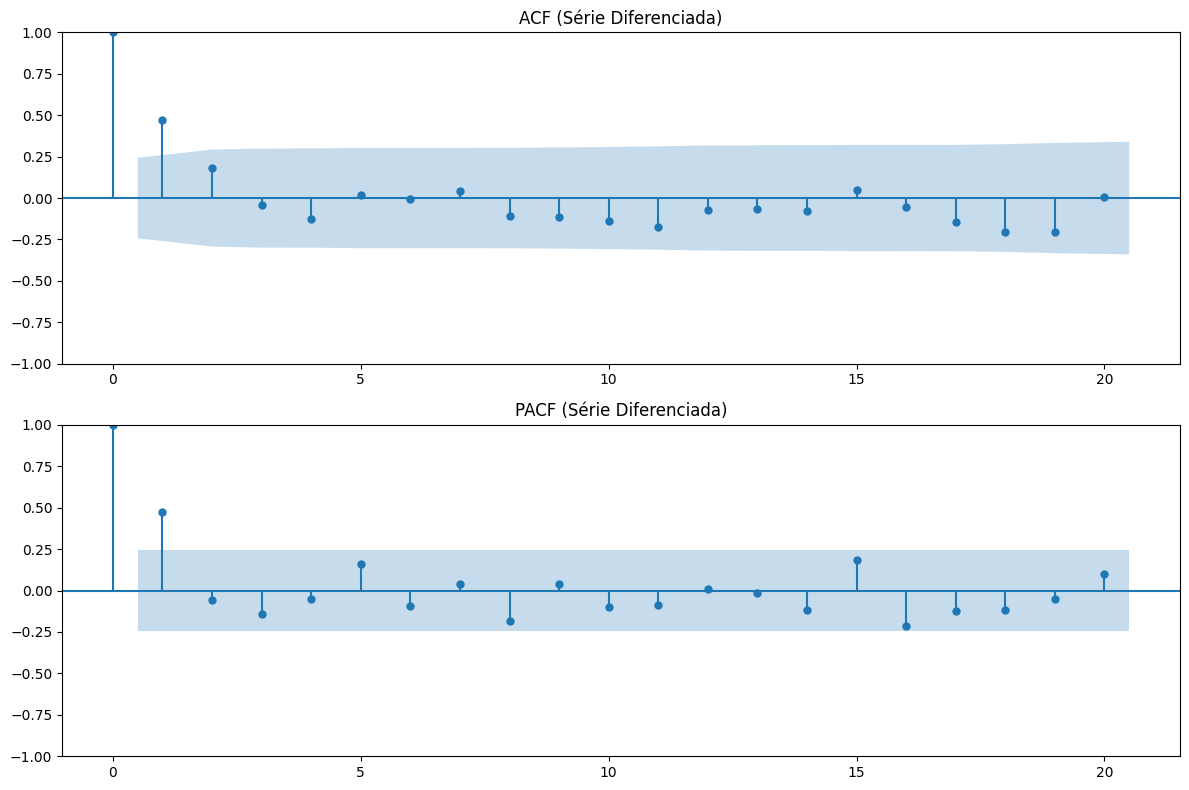

In [7]:
# Visualização ACF e PACF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotar ACF e PACF
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# ACF (Autocorrelation Function) - Ajuda a identificar o parâmetro q (Média Móvel)
plot_acf(ts.diff().dropna(), lags=20, ax=ax[0], title='ACF (Série Diferenciada)')

# PACF (Partial Autocorrelation Function) - Ajuda a identificar o parâmetro p (Auto-regressivo)
plot_pacf(ts.diff().dropna(), lags=20, ax=ax[1], title='PACF (Série Diferenciada)')

plt.tight_layout()
plt.savefig('acf_pacf.png')
plt.show()

In [8]:
# Modelagem preditiva SARIMAX

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Divisão Treino/Teste
# Usar a maior parte para treino e reservar os últimos 6 meses para teste
TAMANHO_TESTE = 6
treino = ts[:-TAMANHO_TESTE]
teste = ts[-TAMANHO_TESTE:]

# Implementação do Modelo SARIMAX
# Os parâmetros (p, d, q) e (P, D, Q, S) são definidos após a análise ACF/PACF.
# Exemplo de Parâmetros (Ajuste conforme sua análise ADF/ACF/PACF):
order = (1, 1, 1) # (p, d, q)
seasonal_order = (1, 1, 1, 12) # (P, D, Q, S=12 meses)

print("Iniciando treinamento do modelo SARIMAX...")

modelo_sarimax = SARIMAX(
    treino,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

resultados = modelo_sarimax.fit(disp=False)
print("Treinamento concluído.")
print(resultados.summary())

Iniciando treinamento do modelo SARIMAX...
Treinamento concluído.
                                     SARIMAX Results                                      
Dep. Variable:                  valor_medio_venda   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -783.642
Date:                            Sun, 30 Nov 2025   AIC                           1577.284
Time:                                    14:40:22   BIC                           1584.767
Sample:                                01-01-2020   HQIC                          1579.802
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5054        nan        nan     

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse


In [9]:
# Previsão no período de Teste e Métricas

from sklearn.metrics import mean_squared_error
import math

# Geração das previsões no período de teste (forecasting)
# Start e end dates são baseadas nos índices do conjunto de teste
predicoes_teste = resultados.get_prediction(start=teste.index[0], end=teste.index[-1])
previsoes = predicoes_teste.predicted_mean

# Cálculo do RMSE (Root Mean Squared Error)
rmse = math.sqrt(mean_squared_error(teste, previsoes))

# Função para cálculo do MAPE (Mean Absolute Percentage Error)
def calcular_mape(y_verdadeiro, y_previsto):
    return np.mean(np.abs((y_verdadeiro - y_previsto) / y_verdadeiro)) * 100

mape = calcular_mape(teste, previsoes)

print("\n--- MÉTRICAS DE PERFORMANCE NO CONJUNTO DE TESTE ---")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")


--- MÉTRICAS DE PERFORMANCE NO CONJUNTO DE TESTE ---
RMSE (Root Mean Squared Error): 0.1356
MAPE (Mean Absolute Percentage Error): 1.64%


In [10]:
# Geração de Previsão Futura

# Prever os próximos 6 meses
HORIZONTE_PREVISAO = 6
previsao_futura = resultados.get_forecast(steps=HORIZONTE_PREVISAO)

# Extrair a média das previsões e os intervalos de confiança (IC)
media_previsao = previsao_futura.predicted_mean
ic_inferior = previsao_futura.conf_int().iloc[:, 0]
ic_superior = previsao_futura.conf_int().iloc[:, 1]

print(f"\n--- PREVISÃO PARA OS PRÓXIMOS {HORIZONTE_PREVISAO} MESES ---")
print(media_previsao)


--- PREVISÃO PARA OS PRÓXIMOS 6 MESES ---
2025-01-01    6.190759
2025-02-01    6.355308
2025-03-01    6.397124
2025-04-01    6.455010
2025-05-01    6.490126
2025-06-01    6.487207
Freq: MS, Name: predicted_mean, dtype: float64


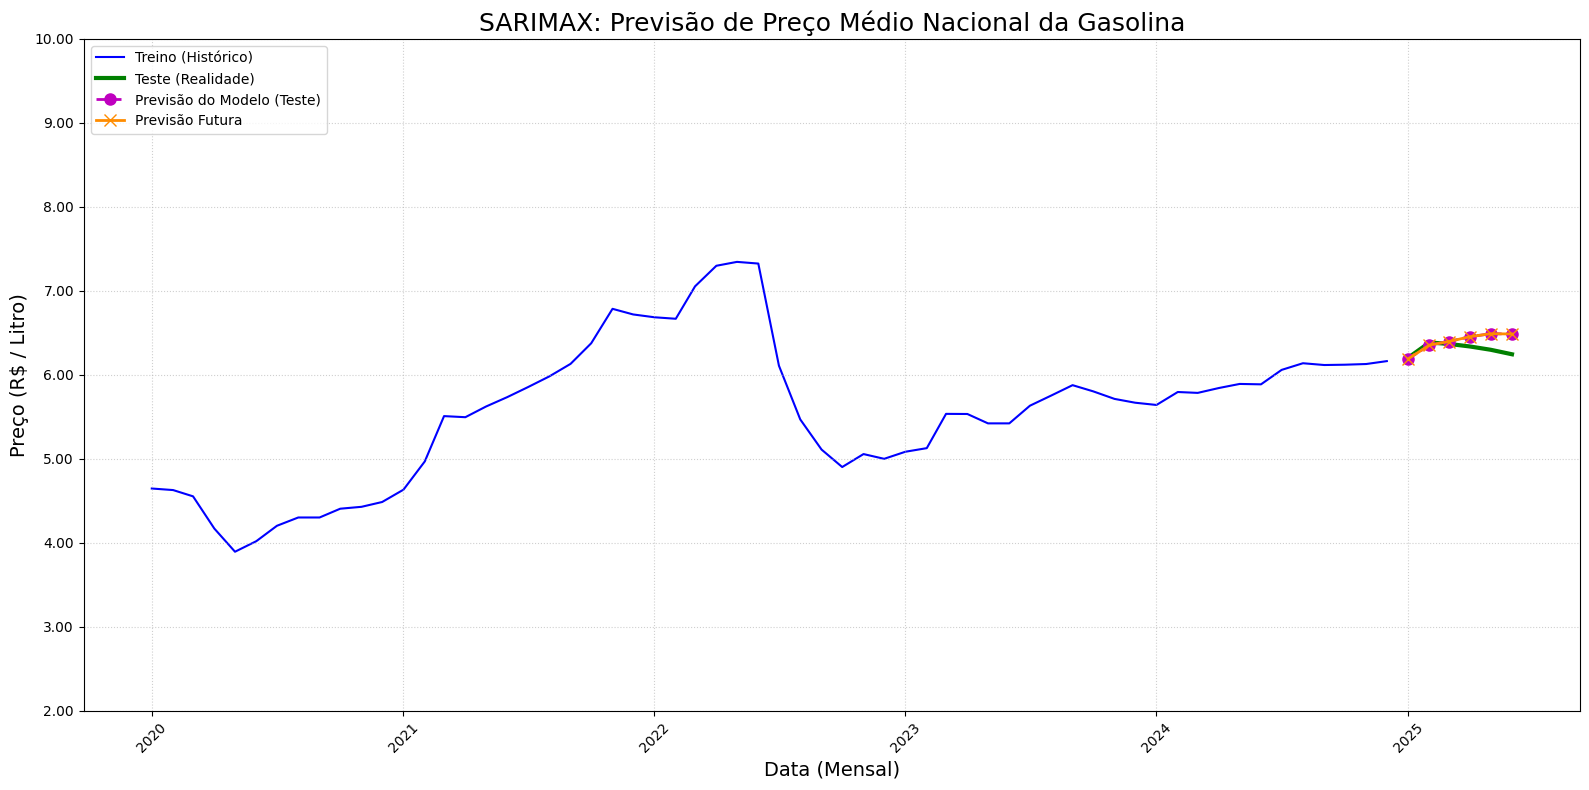

In [20]:
# Visualização Final: Treino, Teste e Forecast

import matplotlib.ticker as mticker

plt.figure(figsize=(16, 8))

# Plotar a série de Treino (Preços Históricos)
plt.plot(treino.index, treino, label='Treino (Histórico)', color='blue', zorder=1)

# Plotar a série de Teste (Realidade)
plt.plot(teste.index, teste, label='Teste (Realidade)', color='green', linewidth=3, zorder=2)

# Plotar as Previsões no Período de Teste
plt.plot(teste.index, previsoes,
         label='Previsão do Modelo (Teste)',
         color='m',
         linestyle='--',
         marker='o',
         markersize=8,
         linewidth=2,
         zorder=3)

# Plotar a Previsão Futura
plt.plot(media_previsao.index, media_previsao,
         label='Previsão Futura',
         color='darkorange',
         marker='x',
         markersize=8,
         linewidth=2,
         zorder=4)

plt.ylim(bottom=2.0, top=10.0)
formatter = mticker.StrMethodFormatter('{x:,.2f}')
plt.gca().yaxis.set_major_formatter(formatter)

# Adicionar Títulos e Legendas
plt.title('SARIMAX: Previsão de Preço Médio Nacional da Gasolina', fontsize=18)
plt.xlabel('Data (Mensal)', fontsize=14)
plt.ylabel('Preço (R$ / Litro)', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

# Salvar e Exibir o Gráfico Final
plt.savefig('sarimax_previsao_final.png')
plt.show()